# Kernels

In [1]:
from google.colab import drive

# Google Drive'ı bağlayın
drive.mount('/content/drive', force_remount=True) # Force remount to re

Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
import scipy
from scipy.spatial.distance import cdist
from scipy.special import gamma

from sklearn.preprocessing import StandardScaler

In [5]:
class Kernels:
  def __init__(self):
    pass

  def dot_product(self,v1,v2):
    return v1.dot(v2)

  def distance(self,X1,X2):
    D = cdist(X1 , X2 , 'euclidean' )
    D[D == 0] = 1e-10
    D[np.isnan(D)] = 1e-10
    return D

  def rbf(self,X1,X2,param1,param2):
    #D2 = cdist(X1 , X2 , 'euclidean' )**2
    #G = np.exp(-param1*D2)
    D = self.distance(X1,X2)**2
    return np.exp(-param1 * D)

  def laplace(self, X1, X2, param1, param2):
    #D1 = cdist(X1 , X2 , 'euclidean' )
    #G = np.exp(-D1/param1 )
    D = self.distance(X1,X2)
    return np.exp(-D / param1)

  def tanh(self,X1,X2,param1,param2):
    #D3 = cdist(X1 , X2 , f_dot )
    #G = np.tanh( param1 * D3 + param2 ) # tanh
    D = cdist(X1, X2, self.dot_product)

    if np.all(D<1e10):
      return np.tanh(param1 * D + param2)

    # tanh = (e^x - e^-x)/ (e^x + e^-x) for large number tanh -> 1
    else:
      return 1

  def lkf(self,X1,X2,param1,param2):
    D = self.distance(X1,X2)**2
    return np.log((D + np.exp(1)*param1) / (D + param1)) # LKF kernel

  """
  def lkf(self,X1,X2,param1,param2):
    #D2 = cdist(X1 , X2 , 'euclidean' )**2
    #G  = np.log( (D2 + np.exp(1)*param1 ) / (D2 + param1 ) );
    D = self.distance(X1,X2)**2
    return np.log((D + np.exp(1)*param1) / (D + param1))
  """
  def levy(self,X1,X2,param1,param2):
    D = self.distance(X1,X2)**2
    return np.sqrt(param1 / (2 * np.pi)) * np.exp(-param1 / (2 * D)) / D**(3/2)

  #def bernstein_1(self,X1,X2,param1):
    #D5= cdist(X1 , X2 , 'euclidean' )**param1
    #G = np.exp(-param1*D5)  #bernstein_1
    #D = self.distance(X1, X2)**param1

    #return np.exp(-param1*D)

  def bernstein_1(self,X1,X2,param1,param2):
    #D5= cdist(X1 , X2 , 'euclidean' )**param1
    #G = np.exp(-param1*D5)  #bernstein_1
    D = self.distance(X1, X2)**(3/2)
    return np.exp(-param1*D)

  #def bernstein_2(self,X1,X2,param1,param2):
    #D=(cdist(X1 , X2 , 'euclidean' )**2)/(cdist(X1 , X2 , 'euclidean' )**2+param2)
    #G=np.exp(-param1*D)  #bernstein_2
    #d = self.distance(X1,X2)**2
    #D = d / (d+param2)
    #return np.exp(-param1*D)
    ######betul####
    ######bu formülü silelim, sıralamayı düzeltelim, bu fonksiyon yok artık.


  def bernstein_2(self, X1, X2, param1, param2):
    #D= (cdist(X1 , X2 , 'euclidean' )**2)/(cdist(X1 , X2 , 'euclidean' )**2+param2)**(1/2)
    #G = np.exp(-param1*D) #bernstein_3
    d = self.distance(X1,X2)
    ######betul####
    ######burada d = self.distance(X1,X2) olması gerekir, karesi değil, bu sonucu düzeltti bu fonksiyon için oldukça
    D = d**2 / np.sqrt(d**2 + param2)
    return np.exp(-param1*D)

  def bernstein_3(self,X1, X2, param1, param2):
    d = self.distance(X1,X2)
    D = d * (1 - np.exp(-2 * param2 * d))
    return np.exp(-param1*D)  #bernstein_3


  def bernstein_4(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    D = np.log(1 + 2 * d ** 2 + 2 * d * np.sqrt(1 + d**2))
    return np.exp(-param1*D) #bernstein_4

  def bernstein_5(self,X1,X2,param1,param2):
     d = self.distance(X1,X2)
     if np.all(d)< 1e10:
      D = d * np.arctan(np.sqrt(d) / param2)

     # arctan approximate pi/2 for large numbers.
     else:
      D = d * (np.pi / 2)
     return np.exp(-param1*D)  #bernstein_5

  def bernstein_6(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)

    if np.all(d) < 1e10:
      D = d * (param1 + np.tanh( param2*d)) / (1 + param1 * np.tanh( param2*d))

    # tanh = (e^x - e^-x)/ (e^x + e^-x) for large number tanh -> 1
    else:
      D = d

    return np.exp(-D) #bernstein_6

  def bernstein_7(self,X1,X2,param1,param2):
    d = np.sqrt(2 * self.distance(X1,X2))
    if np.all( d < 700):
      # D = np.log(np.cosh(d))
      # cosh(x) = e^x + e^-x / 2
      D = np.logaddexp(d, -d) - np.log(2)

    else:
      D = d - np.log(2)

    return np.exp(-param1*D) #bernstein_7

  def bernstein_8(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    D = d * np.log( 1 + param2 * np.tanh(d))
    return np.exp(-param1*D) #bernstein_8

  def bernstein_9(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    D = np.log(np.sqrt(1 + d**2) + d)
    return np.exp(-param1*D) #bernstein_9

  def bernstein_10(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    n_1 = (d**2 + param2) / (2 * param2)
    n_2 = (d**2 / (2 * param2))

    if np.all(d<10): # Mesafe matrisinin tüm elemanları 10'dan küçükse.
      # Gamma hesaplaması
      #print("distance: ",self.distance(X1,X2),"param1:",param1," param2: ",param2," eq: scipy.special.gamma((self.distance(X1,X2)**2+param2)/(2*param2))/scipy.special.gamma((self.distance(X1,X2)/(2*param2)))")
      D = scipy.special.gamma(n_1) / scipy.special.gamma(n_2)

    else:
      #stirling aproximation
      D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
    return np.exp(-param1*D) #bernstein_10

  def __call__(self, X1, X2, kernel_type='rbf', param1=1, param2=1,param3=1):
        if kernel_type == 'rbf':
            return self.rbf(X1, X2, param1,param2)

        elif kernel_type == 'laplace':
            return self.laplace(X1, X2, param1,param2)

        elif kernel_type == 'tanh':
            return self.tanh(X1, X2, param1,param2)

        elif kernel_type == 'lkf':
            return self.lkf(X1, X2, param1,param2)

        elif kernel_type == 'levy':
            return self.levy(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_1':
            return self.bernstein_1(X1,X2,param1,param2)

        elif kernel_type == 'bernstein_2':
            return self.bernstein_2(X1,X2,param1,param2)

        elif kernel_type == 'bernstein_3':
            return self.bernstein_3(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_4':
            return self.bernstein_4(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_5':
            return self.bernstein_5(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_6':
            return self.bernstein_6(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_7':
            return self.bernstein_7(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_8':
            return self.bernstein_8(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_9':
            return self.bernstein_9(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_10':
            return self.bernstein_10(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_11':
            return self.bernstein_11(X1, X2, param1,param2)

        else:
            raise ValueError("Unsupported kernel type")

In [4]:
class Kernels:
  def __init__(self):
    pass

  def dot_product(self,v1,v2):
    return v1.dot(v2)

  def distance(self,X1,X2):
    D = cdist(X1 , X2 , 'euclidean' )
    D[D == 0] = 1e-10
    D[np.isnan(D)] = 1e-10
    return D

  def rbf(self,X1,X2,param1,param2):
    #D2 = cdist(X1 , X2 , 'euclidean' )**2
    #G = np.exp(-param1*D2)
    D = self.distance(X1,X2)**2
    return np.exp(-param1*D)

  def laplace(self,X1,X2,param1,param2):
    #D1 = cdist(X1 , X2 , 'euclidean' )
    #G = np.exp(-D1/param1 )
    D = self.distance(X1,X2)
    return np.exp(-D/param1)

  def tanh(self,X1,X2,param1,param2):
    #D3 = cdist(X1 , X2 , f_dot )
    #G = np.tanh( param1 * D3 + param2 ) # tanh
    D = cdist(X1, X2, self.dot_product)
    if np.all(D<1e10):
      return np.tanh(param1*D + param2)

    # tanh = (e^x - e^-x)/ (e^x + e^-x) for large number tanh -> 1
    else:
      return 1

  def lkf(self,X1,X2,param1,param2):
    #D2 = cdist(X1 , X2 , 'euclidean' )**2
    #G  = np.log( (D2 + np.exp(1)*param1 ) / (D2 + param1 ) );     # LKF kernel
    D = self.distance(X1,X2)**2
    return np.log((D + np.exp(1)*param1) / (D + param1))

  def levy(self,X1,X2,param1,param2):
    D = self.distance(X1,X2)**2
    return np.sqrt(param1 / (2 * np.pi)) * np.exp(-param1 / (2 * D)) / D**(3/2)




  def bernstein_1(self,X1,X2,param1,param2):
    #D5= cdist(X1 , X2 , 'euclidean' )**param1
    #G = np.exp(-param1*D5)  #bernstein_1
    D = self.distance(X1, X2)**(3/2)
    return np.exp(-param1*D)

  def bernstein_2(self,X1,X2,param1,param2):
    #D= (cdist(X1 , X2 , 'euclidean' )**2)/(cdist(X1 , X2 , 'euclidean' )**2+param2)**(1/2)
    #G = np.exp(-param1*D) #bernstein_3
    d = self.distance(X1,X2)
    ######betul####
    ######burada d = self.distance(X1,X2) olması gerekir, degistirdim
    D = d**2 / np.sqrt(d**2 + param2)
    return np.exp(-param1*D)



  def bernstein_3(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    D = d * (1 - np.exp(-2 * param2 * d))
    return np.exp(-param1*D)  #bernstein_3

  def bernstein_4(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    D = np.log(1 + 2 * d ** 2 + 2 * d * np.sqrt(1 + d**2))
    return np.exp(-param1*D) #bernstein_4

  def bernstein_5(self,X1,X2,param1,param2):
     d = self.distance(X1,X2)
     if np.all(d)< 1e10:
      D = d * np.arctan(np.sqrt(d / param2))

     # arctan approximate pi/2 for large numbers.
     else:
      D = d * (np.pi / 2)
     return np.exp(-param1*D)  #bernstein_5

  def bernstein_6(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    ######betul####
    ######burada param3 ü sildim
    if np.all(d) < 1e10:

      D = d * (param1 + np.tanh( (param2*d))) / (1 + param1 * np.tanh( (param2*d)))


    # tanh = (e^x - e^-x)/ (e^x + e^-x) for large number tanh -> 1
    else:
      D = d

    return np.exp(-D) #bernstein_6

  def bernstein_7(self,X1,X2,param1,param2):
    d = np.sqrt(2 * self.distance(X1,X2))
    if np.all( d < 700):
      # D = np.log(np.cosh(d))
      # cosh(x) = e^x + e^-x / 2
      D = np.logaddexp(d, -d) - np.log(2)

    else:
      D = d - np.log(2)

    return np.exp(-param1*D) #bernstein_7

  def bernstein_8(self,X1,X2,param1,param2):
    ######betul####
    ######burada param3 ü sildim
    d = self.distance(X1,X2)
    D = d * np.log( 1 + param2 * np.tanh( d))
    return np.exp(-param1*D) #bernstein_8

  def bernstein_9(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    D = np.log(np.sqrt(1 + d**2) + d)
    return np.exp(-param1*D) #bernstein_9


  def bernstein_10(self,X1,X2,param1,param2):
    d = self.distance(X1,X2)
    n_1 = (d**2 + param2) / (2 * param2)
    n_2 = (d**2 / (2 * param2))

    if np.all(d<10): # Mesafe matrisinin tüm elemanları 10'dan küçükse.
      # Gamma hesaplaması
      #print("distance: ",self.distance(X1,X2),"param1:",param1," param2: ",param2," eq: scipy.special.gamma((self.distance(X1,X2)**2+param2)/(2*param2))/scipy.special.gamma((self.distance(X1,X2)/(2*param2)))")
      D = scipy.special.gamma(n_1) / scipy.special.gamma(n_2)

    else:
      D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
    return np.exp(-param1*D) #bernstein_10

  def __call__(self, X1, X2, kernel_type='rbf', param1=1, param2=1):
        if kernel_type == 'rbf':
            return self.rbf(X1, X2, param1,param2)

        elif kernel_type == 'laplace':
            return self.laplace(X1, X2, param1,param2)

        elif kernel_type == 'tanh':
            return self.tanh(X1, X2, param1,param2)

        elif kernel_type == 'lkf':
            return self.lkf(X1, X2, param1,param2)

        elif kernel_type == 'levy':
            return self.levy(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_1':
            return self.bernstein_1(X1,X2,param1,param2)

        elif kernel_type == 'bernstein_2':
            return self.bernstein_2(X1,X2,param1,param2)

        elif kernel_type == 'bernstein_3':
            return self.bernstein_3(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_4':
            return self.bernstein_4(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_5':
            return self.bernstein_5(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_6':
            return self.bernstein_6(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_7':
            return self.bernstein_7(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_8':
            return self.bernstein_8(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_9':
            return self.bernstein_9(X1, X2, param1,param2)

        elif kernel_type == 'bernstein_10':
            return self.bernstein_10(X1, X2, param1,param2)

        else:
            raise ValueError("Unsupported kernel type")

# Random Search Optimizer

In [6]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.optimize import linear_sum_assignment
import time
from sklearn.datasets import load_iris

class KernelOptimizer:
  def __init__(self, X_train, X_test, y_test, n_clusters, kernel_type):
      self.X_train = X_train
      self.X_test = X_test
      self.y_test = y_test
      self.n_clusters = n_clusters
      self.kernel_type = kernel_type

  def pred_labels2mapped_labels(self, pred_labels, y_test):
      from sklearn.metrics import confusion_matrix
      conf_matrix = confusion_matrix(y_test, pred_labels)
      row_ind, col_ind = linear_sum_assignment(-conf_matrix)
      mapping = {old: new for old, new in zip(col_ind, row_ind)}
      return [mapping[label] for label in pred_labels]

  def clustering_metrics(self, labels, data):
      if len(set(labels)) > 1:
          silhouette = silhouette_score(data, labels)
          davies_bouldin = davies_bouldin_score(data, labels)

          unique_labels = np.unique(labels)
          overall_mean = np.mean(data, axis=0)
          between_class_variance = np.sum([len(data[labels == label]) * np.sum((np.mean(data[labels == label], axis=0) - overall_mean) ** 2) for label in unique_labels])
          within_class_variance = np.sum([np.sum((data[labels == label] - np.mean(data[labels == label], axis=0)) ** 2) for label in unique_labels])
          fisher_score = between_class_variance / within_class_variance if within_class_variance != 0 else 0

          return {"Silhouette": float(silhouette), "Davies-Bouldin": float(davies_bouldin), "Fisher": float(fisher_score)}
      return {"Silhouette": -1, "Davies-Bouldin": 0, "Fisher": -float('inf')}

  def MLA(self, gamma_values, dim):
      """Apply Kernel PCA and KMeans clustering."""
      kernels = Kernels()  # Assuming Kernels class is defined


      train_kernel_matrix = np.array(kernels(X_train, X_train, kernel_type=self.kernel_type, param1=gamma_values[0], param2=gamma_values[1]))
      test_kernel_matrix = np.array(kernels(X_test, X_train, kernel_type=self.kernel_type, param1=gamma_values[0], param2=gamma_values[1]))

      train_kernel_matrix = np.nan_to_num(train_kernel_matrix)
      test_kernel_matrix = np.nan_to_num(test_kernel_matrix)

      kpca = KernelPCA(n_components=dim, kernel='precomputed')
      kpca.fit(train_kernel_matrix)
      X_train_kernel_pca = kpca.transform(train_kernel_matrix)
      X_test_kernel_pca = kpca.transform(test_kernel_matrix)

      kmeans = KMeans(n_clusters=self.n_clusters, init="k-means++")
      kmeans.fit(X_train_kernel_pca)
      return kmeans.predict(X_test_kernel_pca)

  def calculate_metrics(self, labels_test):
      if len(set(labels_test)) > 1:
          mapped_labels = self.pred_labels2mapped_labels(labels_test, self.y_test)
          accuracy = accuracy_score(self.y_test, mapped_labels)
          metrics = self.clustering_metrics(mapped_labels, self.X_test)
          return accuracy, metrics
      return None, None

  def random_search(self, gamma_range, dim_range, n_iterations=50):
      results = []
      start_time = time.time()
      best_fisher_score = -float('inf')

      for _ in range(n_iterations):
          try:

              gamma_values = [np.exp(np.random.uniform(np.log(gamma_range[0]),np.log(gamma_range[1]))),
                              np.exp(np.random.uniform(np.log(gamma_range[0]), np.log(gamma_range[1])))]


              dim = int(np.random.uniform(dim_range[0], dim_range[1]))

              labels_test = self.MLA(gamma_values, dim)
              accuracy, metrics = self.calculate_metrics(labels_test)

              if (accuracy is not None) and (metrics["Fisher"] > best_fisher_score):
                  best_fisher_score = metrics["Fisher"]
                  results = {
                      "kernel_type": self.kernel_type,
                      "accuracy": round(accuracy, 6),
                      "metrics": {k: round(v, 6) for k, v in metrics.items()},
                      "params": [float(round(x, 10)) for x in gamma_values],
                      "dim": dim,
                      "n_clusters": self.n_clusters,
                      "optimization_time": round(time.time() - start_time, 6),
                      "labels": len(set(labels_test))
                  }
          except Exception as e:
              print(f"Error during optimization: {e}")
              continue

      return results if results else None

# Cross Val

In [7]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np

def clustering_metrics(labels, data):
      if len(set(labels)) > 1:
          silhouette = silhouette_score(data, labels)
          davies_bouldin = davies_bouldin_score(data, labels)

          unique_labels = np.unique(labels)
          overall_mean = np.mean(data, axis=0)
          between_class_variance = np.sum([len(data[labels == label]) * np.sum((np.mean(data[labels == label], axis=0) - overall_mean) ** 2) for label in unique_labels])
          within_class_variance = np.sum([np.sum((data[labels == label] - np.mean(data[labels == label], axis=0)) ** 2) for label in unique_labels])
          fisher_score = between_class_variance / within_class_variance if within_class_variance != 0 else 0

          return {"Silhouette": float(silhouette), "Davies-Bouldin": float(davies_bouldin), "Fisher": float(fisher_score)}
      return {"Silhouette": -1, "Davies-Bouldin": 0, "Fisher": -float('inf')}


def pred_labels2mapped_labels(pred_labels, y_test):
        """Map predicted labels to true labels using Hungarian method."""
        from sklearn.metrics import confusion_matrix
        conf_matrix = confusion_matrix(y_test, pred_labels)
        row_ind, col_ind = linear_sum_assignment(-conf_matrix)
        mapping = {old: new for old, new in zip(col_ind, row_ind)}
        try:
          return [mapping[label] for label in pred_labels]
        except:
          return None


from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
import pandas as pd
import time

def cross_val(X, y, kernel_type, n_clusters, dim, gamma_values):

    kernels = Kernels()

    silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores, fisher_scores,acc_scores = [], [], [], [],[]
    iteration_times = []  # Her iterasyondaki süreyi tutmak için

    kfold = StratifiedKFold(n_splits=3) #kfold number

    for train_index, test_index in kfold.split(X, np.zeros(X.shape[0])):
        start_time = time.time()  # İterasyon başlangıç zamanı
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        if len(gamma_values) == 1:
            train_kernel_matrix = np.array(kernels(X_train, X_train, kernel_type=kernel_type, param1=gamma_values[0]))
            test_kernel_matrix = np.array(kernels(X_test, X_train,  kernel_type=kernel_type, param1=gamma_values[0]))
        elif len(gamma_values) == 2:
            train_kernel_matrix = np.array(kernels(X_train, X_train, kernel_type=kernel_type, param1=gamma_values[0], param2=gamma_values[1]))
            test_kernel_matrix = np.array(kernels(X_test, X_train, kernel_type=kernel_type, param1=gamma_values[0], param2=gamma_values[1]))
        elif len(gamma_values) == 3:
            train_kernel_matrix = np.array(kernels(X_train, X_train, kernel_type=kernel_type, param1=gamma_values[0], param2=gamma_values[1], param3=gamma_values[2]))
            test_kernel_matrix = np.array(kernels(X_test, X_train, kernel_type=kernel_type, param1=gamma_values[0], param2=gamma_values[1], param3=gamma_values[2]))


        train_kernel_matrix = np.nan_to_num(train_kernel_matrix)
        test_kernel_matrix = np.nan_to_num(test_kernel_matrix)

        train_kernel_matrix = pd.DataFrame(train_kernel_matrix)
        test_kernel_matrix = pd.DataFrame(test_kernel_matrix)

        # KernelPCA
        kpca = KernelPCA(n_components=dim, kernel='precomputed')
        kpca.fit(train_kernel_matrix)

        # Apply Kernel PCA transformation
        X_train_kernel_pca = kpca.transform(train_kernel_matrix)
        X_test_kernel_pca = kpca.transform(test_kernel_matrix)

        # KMeans clustering (n_clusters is fixed, not part of the optimization)
        kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
        kmeans.fit(X_train_kernel_pca)
        labels_test = kmeans.predict(X_test_kernel_pca)


        mapped_labels = pred_labels2mapped_labels(labels_test, y_test)

        if mapped_labels==None:
          continue

        # Metriği hesaplama
        metrics = clustering_metrics(mapped_labels, X_test_kernel_pca)
        silhouette_scores.append(metrics['Silhouette'])
        davies_bouldin_scores.append(metrics['Davies-Bouldin'])
        fisher_scores.append(metrics['Fisher'])
        acc_scores.append(accuracy_score(y_test, mapped_labels))

        # İterasyon bitiş zamanı ve süre hesaplama
        elapsed_time = time.time() - start_time
        iteration_times.append(elapsed_time)

    silhouette_scores=np.array(silhouette_scores)[np.isfinite(silhouette_scores)]
    davies_bouldin_scores=np.array(davies_bouldin_scores)[np.isfinite(davies_bouldin_scores)]
    fisher_scores=np.array(fisher_scores)[np.isfinite(fisher_scores)]


    return {
        "kernel_type": kernel_type,
        'n_clusters': n_clusters,
        'dim': dim,
        "gamma_values": gamma_values,
        'Accuracy': f"{np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}",
        'Silhouette': f"{np.mean(silhouette_scores):.4f} ± {np.std(silhouette_scores):.4f}",
        'Davies-Bouldin': f"{np.mean(davies_bouldin_scores):.4f} ± {np.std(davies_bouldin_scores):.4f}",
        'Fisher': f"{np.mean(fisher_scores):.4f} ± {np.std(fisher_scores):.4f}",
        'Elapsed Time (s)': f"{np.mean(iteration_times):.4f} ± {np.std(iteration_times):.4f}"
    }

def cross_val_all_data(X, y, n_clusters):
  kernels = Kernels()

  silhouette_scores, davies_bouldin_scores, calinski_harabasz_scores, fisher_scores, acc_scores = [], [], [], [], []
  iteration_times = []  # Her iterasyondaki süreyi tutmak için
  kfold = StratifiedKFold(n_splits=10)

  for train_index, test_index in kfold.split(X, np.zeros(X.shape[0])):
      start_time = time.time()  # İterasyon başlangıç zamanı
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # KMeans clustering (n_clusters is fixed, not part of the optimization)
      kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
      kmeans.fit(X_train)
      labels_test = kmeans.predict(X_test)

      mapped_labels = pred_labels2mapped_labels(labels_test, y_test)

      if mapped_labels==None:
        continue


      # Metriği hesaplama
      metrics = clustering_metrics(mapped_labels, X_test)
      silhouette_scores.append(metrics['Silhouette'])
      davies_bouldin_scores.append(metrics['Davies-Bouldin'])
      fisher_scores.append(metrics['Fisher'])
      acc_scores.append(accuracy_score(y_test, mapped_labels))

      # İterasyon bitiş zamanı ve süre hesaplama
      elapsed_time = time.time() - start_time
      iteration_times.append(elapsed_time)

  silhouette_scores=np.array(silhouette_scores)[np.isfinite(silhouette_scores)]
  davies_bouldin_scores=np.array(davies_bouldin_scores)[np.isfinite(davies_bouldin_scores)]
  fisher_scores=np.array(fisher_scores)[np.isfinite(fisher_scores)]


  return {
      "kernel_type": kernel_type,
      'n_clusters': n_clusters,
      'dim': X_test.shape[1],
      "gamma_values": None,
      'Accuracy': f"{np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}",
      'Silhouette': f"{np.mean(silhouette_scores):.3f} ± {np.std(silhouette_scores):.3f}",
      'Davies-Bouldin': f"{np.mean(davies_bouldin_scores):.3f} ± {np.std(davies_bouldin_scores):.3f}",
      'Fisher': f"{np.mean(fisher_scores):.3f} ± {np.std(fisher_scores):.3f}",
      'Elapsed Time (s)': f"{np.mean(iteration_times):.4f} ± {np.std(iteration_times):.4f}"
  }

def append_and_save_results(res, n_clusters, X, y):
    """
    Her iterasyondaki sonucu bir DataFrame'e ekler ve işlemler tamamlandığında Excel dosyasına kaydeder.

    Parametreler:
    - res: Her iterasyonun sonucu olan sözlük (dictionary).
    - n_clusters: KMeans için küme sayısı.
    - X: Veri kümesi.
    - results_df: Tüm iterasyonları biriktireceğimiz DataFrame.
    - output_file: Excel dosyasının ismi (varsayılan: 'clustering_results.xlsx').
    """
    # Kernel tipini ve gamma değerlerini almak
    kernel_type = res['kernel_type']
    best_gamma = res['params']
    gamma_values = [item for sublist in best_gamma for item in sublist] if isinstance(best_gamma[0], list) else best_gamma


    dim = res['dim']

    # Çapraz doğrulama sonuçlarını hesaplama
    cross_validation = cross_val(X.copy(), y, kernel_type, n_clusters, dim, gamma_values)

    # Sonuçları DataFrame'e ekleme
    iteration_result = {
        'kernel_type': kernel_type,
        'dim': dim,
        'Silhouette': cross_validation['Silhouette'],
        'Davies-Bouldin': cross_validation['Davies-Bouldin'],
        'Fisher': cross_validation['Fisher'],
        'Accuracy': cross_validation['Accuracy'],
        'Elapsed Time (s)': cross_validation['Elapsed Time (s)'],
        'gamma_values': gamma_values
    }

    return iteration_result  # Güncellenmiş DataFrame'i döndürme


# Data

## Spiral

In [8]:
def create_spiral_2D(n_points_per_class, n_classes, noise=0.1):
    """
    Spiral veri seti oluşturur.

    Parameters:
        n_points_per_class: Her sınıf için kaç veri noktası üretileceği.
        n_classes: Sınıf sayısı (örneğin, 3 sınıf için).
        noise: Verilere eklenebilecek rastgele gürültü miktarı.

    Returns:
        X: Özellik matrisi (n_samples, 2).
        y: Sınıf etiketleri (n_samples,).
    """
    X = []
    y = []

    for class_number in range(n_classes):
        ix = range(n_points_per_class * class_number, n_points_per_class * (class_number + 1))
        r = np.linspace(0.0, 1, n_points_per_class)  # Yarıçap
        t = np.linspace(class_number * 4, (class_number + 1) * 4, n_points_per_class) + np.random.randn(n_points_per_class) * noise  # Açı
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        X.append(np.c_[x1, x2])
        y.append(np.full(n_points_per_class, class_number))

    X = np.vstack(X)
    y = np.hstack(y)
    return X, y

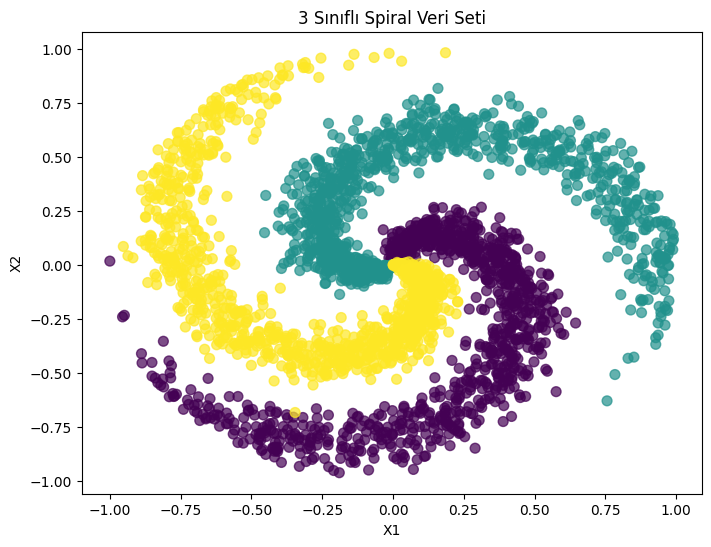

3


In [9]:
X, y = create_spiral_2D(1000, 3 , noise=0.3)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", s=50, alpha=0.7)
plt.title("3 Sınıflı Spiral Veri Seti")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)
print(len(np.unique(y_test)))

## Rice

In [13]:
!pip install ucimlrepo

In [14]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
rice_cammeo_and_osmancik = fetch_ucirepo(id=545)

# data (as pandas dataframes)
X = rice_cammeo_and_osmancik.data.features
y = rice_cammeo_and_osmancik.data.targets

print(X.shape)

from sklearn.preprocessing import LabelEncoder

# Hedef değişken (categorical) için LabelEncoder kullanımı
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# metadata
print(rice_cammeo_and_osmancik.metadata)

# variable information
print(rice_cammeo_and_osmancik.variables)


# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

# Print results
print("")
print(len(np.unique(y_test)))
print(np.unique(y_test))
print(X_train.shape)

(3810, 7)
{'uci_id': 545, 'name': 'Rice (Cammeo and Osmancik)', 'repository_url': 'https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik', 'data_url': 'https://archive.ics.uci.edu/static/public/545/data.csv', 'abstract': "A total of 3810 rice grain's images were taken for the two species, processed and feature inferences were made. 7 morphological features were obtained for each grain of rice.", 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 3810, 'num_features': 7, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5MW4Z', 'creators': [], 'intro_paper': {'ID': 276, 'type': 'NATIVE', 'title': 'Classification of Rice Varieties Using Artificial Intelligence Methods', 'authors': 'Ilkay Cinar, M. Koklu', 'venue': 'International Journa

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Dry Bean

In [12]:
!pip install ucimlrepo

KeyboardInterrupt: 

In [ ]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import pandas as pd

# Fetch dataset
dry_bean = fetch_ucirepo(id=602)

# Data (as pandas DataFrames)
X = dry_bean.data.features
y = dry_bean.data.targets

# Combine X and y into a single DataFrame for sampling
data = pd.concat([X, y], axis=1)

# Use only 10% of the data
data = data.sample(frac=0.1, random_state=42).reset_index(drop=True)

print(data.shape)

# Separate features and target
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Convert y to numeric categorical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

# Metadata
print(dry_bean.metadata)

# Variable information
print(dry_bean.variables)

# Print results
print("")
print(len(np.unique(y_test)))  # Number of unique categories in y_test
print(np.unique(y_test))
print(X_train.shape)          # Shape of training feature set

## Frogs

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Frogs_MFCCs.csv")
#df.drop(["Unnamed: 0"],axis=1,inplace=True)
# Silinecek sütunlar
columns_to_drop = ['Family', 'Genus', 'Species', 'RecordID']

# Sütunları sil
df = df.drop(columns=columns_to_drop, errors='ignore')

print(df)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Separate features and target
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

# Convert y to numeric categorical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)

# Print results
print(len(np.unique(y_test)))  # Number of unique categories in y_test
print(X_train.shape)          # Shape of training feature set

## Stroke

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
#https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset



df = pd.read_csv("/content/drive/My Drive/healthcare-dataset-stroke-data.csv")
df.drop(["id"],axis=1,inplace=True)
df.dropna(inplace=True)
#print(df)



# Separate features and target
categorical_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

# Initialize LabelEncoder
encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Standart Scale

#print(df.head())
y = df["stroke"].values
X = df.drop(["stroke"],axis=1).values
print(X.shape)



scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)

print(X_train.shape)
print(len(np.unique(y_test)))
print(np.unique(y_test))

##Breast Cancer

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X, y = data.data, data.target

# Özellikleri standartlaştır
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

print(X.shape)
print(len(np.unique(y_test)))  # Number of unique categories in y_test
print(np.unique(y_test))
print(X_train.shape)

# Work Place

## Test

In [ ]:
from ucimlrepo import fetch_ucirepo

Wifi indoor localization dataset

In [ ]:
import pandas as pd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler #

# Veri dosyasını yükle (ayraç boşluk veya tab olabilir)
df = pd.read_csv("/content/drive/My Drive/wifi_localization.txt", delim_whitespace=True, header=None)

# Özellikler (X): son sütun hariç tüm sütunlar
X = df.iloc[:, :-1]

# Etiketler (y): son sütun
y = df.iloc[:, -1]

# Özellikleri standartlaştır
scaler = StandardScaler()

X = scaler.fit_transform(X)

# Train-test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

print(X.shape)
print(len(np.unique(y_test)))  # Number of unique categories in y_test
print(np.unique(y_test))
print(X_train.shape)

(2000, 7)
4
[1 2 3 4]
(800, 7)


<ipython-input-108-d564d7717e95>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("/content/drive/My Drive/wifi_localization.txt", delim_whitespace=True, header=None)


In [15]:
n_clusters = len(np.unique(y_test))
n = X_test.shape[1]

optimizer = KernelOptimizer(X_train=X_train, X_test=X_test, y_test=y_test, n_clusters=n_clusters, kernel_type="bernstein_1")
best_result = optimizer.random_search(gamma_range=[1e-10, 1e+10], dim_range=[1, n], n_iterations = 50)
print(best_result)

{'kernel_type': 'bernstein_1', 'accuracy': 0.91951, 'metrics': {'Silhouette': 0.413733, 'Davies-Bouldin': 0.943516, 'Fisher': 0.934135}, 'params': [0.120401861, 74756.2526572485], 'dim': 5, 'n_clusters': 2, 'optimization_time': 40.272493, 'labels': 2}


## Work Place Random Search Optimizer

In [ ]:
# Initialize KernelOptimizer with required parameters
n_clusters = len(np.unique(y_test))
n = X_test.shape[1]

best_results = []

kernel_types = ["rbf", "laplace", "lkf", "bernstein_1", "bernstein_2","bernstein_3","bernstein_4","bernstein_5","bernstein_6", "bernstein_7", "bernstein_8", "bernstein_9","bernstein_10"]

# Optimize and get best result
for kernel_type in kernel_types:
  best_result = None
  while best_result is None:
    optimizer = KernelOptimizer(X_train=X_train, X_test=X_test, y_test=y_test, n_clusters=n_clusters, kernel_type=kernel_type)
    best_result = optimizer.random_search(gamma_range=[1e-10, 1e+10], dim_range=[1, n], n_iterations = 50)
    best_results.append(best_result)
  print(best_result)

{'kernel_type': 'rbf', 'accuracy': 0.91951, 'metrics': {'Silhouette': 0.413594, 'Davies-Bouldin': 0.944139, 'Fisher': 0.934136}, 'params': [0.0828081577, 13999372.441480191], 'dim': 2, 'n_clusters': 2, 'optimization_time': 12.926842, 'labels': 2}
{'kernel_type': 'laplace', 'accuracy': 0.918635, 'metrics': {'Silhouette': 0.413592, 'Davies-Bouldin': 0.944067, 'Fisher': 0.934241}, 'params': [6.5489070975, 48076.5750510598], 'dim': 2, 'n_clusters': 2, 'optimization_time': 11.639036, 'labels': 2}
{'kernel_type': 'lkf', 'accuracy': 0.918635, 'metrics': {'Silhouette': 0.413801, 'Davies-Bouldin': 0.942702, 'Fisher': 0.934163}, 'params': [21.3540799554, 308.2310993485], 'dim': 3, 'n_clusters': 2, 'optimization_time': 2.25591, 'labels': 2}
{'kernel_type': 'bernstein_1', 'accuracy': 0.919073, 'metrics': {'Silhouette': 0.413804, 'Davies-Bouldin': 0.942933, 'Fisher': 0.934147}, 'params': [0.0727950237, 245999.9711388581], 'dim': 4, 'n_clusters': 2, 'optimization_time': 23.411699, 'labels': 2}
{'ker

/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)


Error during optimization: ARPACK error -9: Starting vector is zero.


/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)


Error during optimization: ARPACK error -9: Starting vector is zero.


/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:153: RuntimeWarning: overflow encountered in multiply
  return np.exp(-param1*D) #bernstein_10
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in power
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)


Error during optimization: ARPACK error -9: Starting vector is zero.


/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)


Error during optimization: ARPACK error -9: Starting vector is zero.


/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in power
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)


Error during optimization: ARPACK error -9: Starting vector is zero.


/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)


Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.


/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in power
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: invalid value encountered in multiply
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)


Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.


/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in power
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)


Error during optimization: ARPACK error -9: Starting vector is zero.


/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in power
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in multiply
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-131252581.py:152: RuntimeWarning: overflow encountered in exp
  D = (n_1**((d**2) / 2 * param2)) * (n_2**((param2 - d) / 2 * param2)) * np.exp((d - (d**2) - param2) / param2)
/tmp/ipython-input-1312

Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
Error during optimization: ARPACK error -9: Starting vector is zero.
{'kernel_type': 'bernstein_10', 'accuracy': 0.912511, 'metrics': {'Silhouette': 0.414344, 'Davies-Bouldin': 0.937571, 'Fisher': 0.930912}, 'params': [0.0002658884, 8.1971803229], 'dim': 1, 'n_clusters': 2, 'optimization_time': 13.77442, 'labels': 2}


## Cross Val

In [ ]:
#Without Kernels
n_clusters = len(np.unique(y_test))
s_time = time.time()
kmeans = KMeans(n_clusters=n_clusters, init="k-means++")
kmeans.fit(X_train)
labels_test = kmeans.predict(X_test)
mapped_labels = pred_labels2mapped_labels(labels_test, y_test)
accuracy = accuracy_score(y_test, mapped_labels)
metrics = clustering_metrics(mapped_labels, X_test)
f_time = time.time() - s_time

results = [{'kernel_type': "All", 'metrics': metrics, 'accuracy': accuracy, 'params': None, 'dim': None, 'n_clusters': len(np.unique(y_test)), 'optimization_time': f_time, 'fisher_score': metrics['Fisher'], 'labels': None}]
#Without Kernels

results_df = pd.DataFrame()  # Initialize results_df as an empty DataFrame
n_clusters = len(np.unique(y_test))

results.extend(best_results)

print(results)

# Optimal sonuçlar listesini yineleyerek her birini DataFrame'e ekleme
for res in results:
  #print(res) # This line can be removed or commented out for cleaner output
  if res is not None and res['kernel_type'] == "All": # Check if res is not None before accessing its elements
      all_data_result = cross_val_all_data(pd.DataFrame(X), pd.DataFrame(y), n_clusters)  # Get result for 'All Data'
      results_df = pd.DataFrame([all_data_result])  # Create DataFrame from 'All Data' result
      continue

  if res is not None: # Check if res is not None before proceeding
      iteration_result = append_and_save_results(res, n_clusters, pd.DataFrame(X), pd.DataFrame(y))
      print(iteration_result) # This line can be removed or commented out for cleaner output
      results_df = pd.concat([results_df, pd.DataFrame([iteration_result])], ignore_index=True)


output_file = '/content/drive/My Drive/yeni_rice.xlsx'
results_df.loc[0, 'kernel_type'] = "All"
results_df.to_excel(output_file, index=False)

# Understanding of Clustering Metrics

In [ ]:
"""
1. Silhouette Skoru
Skor Aralığı: -1 ile +1 arasında değer alır.
1: Mükemmel kümeleme. Veri noktası, kendi kümesine çok yakın, diğer kümelerden çok uzak.
0: Veri noktası, iki farklı küme arasında belirsiz bir noktada. Kendi kümesine ve diğer kümeye eşit uzaklıkta.
-1: Kötü kümeleme. Veri noktası, yanlış kümede yer alıyor ve diğer kümeye daha yakın.

İyi Kümeleme Durumu:
Genel Silhouette skoru 0.5 ve üzeri: Kümeler arasında belirgin bir ayrışma var, veri noktaları kendi kümesine iyi uyum sağlıyor.

Kötü Kümeleme Durumu:
Genel Silhouette skoru 0.2’nin altında: Veri noktaları, yanlış kümede yer alıyor veya kümeler arasındaki ayrım zayıf.



2. Davies-Bouldin Endeksi
Skor Aralığı: 0 ve üzeri değerler alır. Daha düşük skorlar daha iyi bir durumu gösterir.
0: Mükemmel bir kümeleme durumu, kümeler tamamen ayrışmış.
Daha yüksek değerler: Kümeler arasındaki benzerlik artar ve iç tutarlılık azalır.

İyi Kümeleme Durumu:
Davies-Bouldin skoru 0.5’in altında: Kümeler arasında belirgin bir ayrım var ve iç yapı tutarlı.

Kötü Kümeleme Durumu:
Davies-Bouldin skoru 1.0 ve üzeri: Kümeler arasındaki ayrım zayıf, yani kümeler birbirine çok yakın.



4. Fisher Metriği

Çok Kötü Kümeleme (Fisher < 0)
Kötü Kümeleme (0 ≤ Fisher < 1)
Orta Düzeyde Kümeleme (1 ≤ Fisher < 3)
İyi Kümeleme (3 ≤ Fisher < 5)
Çok İyi Kümeleme (5 ≤ Fisher < 10)
Mükemmel Kümeleme (Fisher ≥ 10)

"""